<a href="https://colab.research.google.com/github/IlyessAgg/mLproject/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (3/3), done.


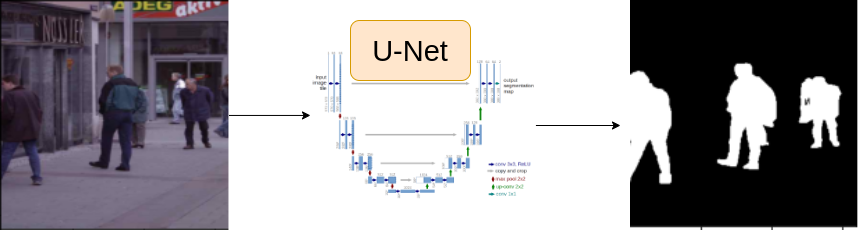

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.001
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

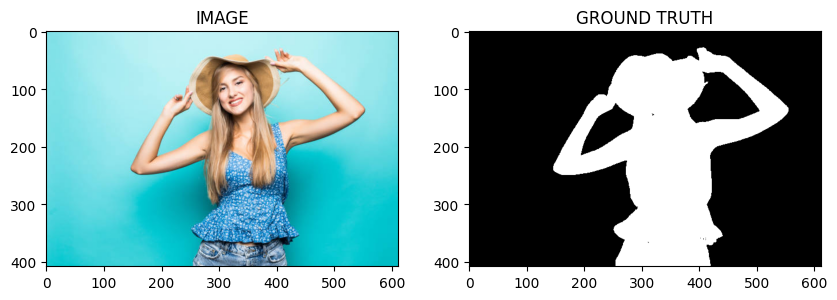

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


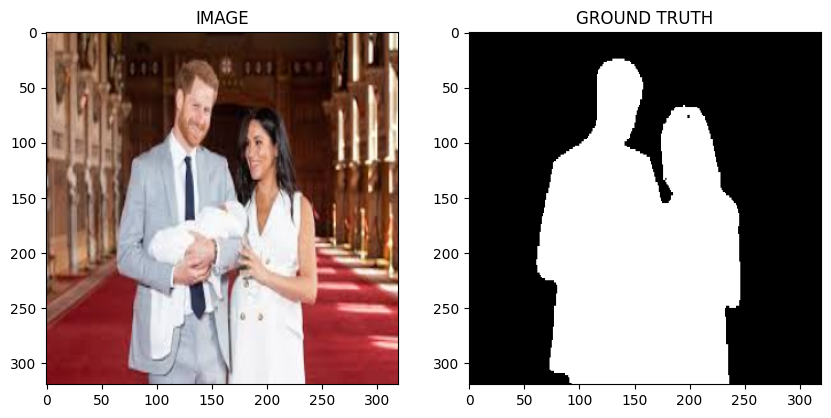

In [ ]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.9094932556152344 Valid loss : 0.6898636519908905


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.4381378630797068 Valid loss : 0.27893439680337906


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


SAVED MODEL
Epoch : 3 Train_loss : 0.28361124396324155 Valid loss : 0.24289574474096298


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.23661170303821563 Valid loss : 0.20274438709020615


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch : 5 Train_loss : 0.19414921899636586 Valid loss : 0.23230167850852013


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


SAVED MODEL
Epoch : 6 Train_loss : 0.18031839927037557 Valid loss : 0.1927371323108673


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


SAVED MODEL
Epoch : 7 Train_loss : 0.15673307726780575 Valid loss : 0.18312976136803627


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch : 8 Train_loss : 0.17414742112159728 Valid loss : 0.1846948340535164


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 9 Train_loss : 0.18108342885971068 Valid loss : 0.1936757080256939


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch : 10 Train_loss : 0.15522342572609585 Valid loss : 0.22521282359957695


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 11 Train_loss : 0.1825363223751386 Valid loss : 0.1836366057395935


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 12 Train_loss : 0.13615394681692122 Valid loss : 0.19495509937405586


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


SAVED MODEL
Epoch : 13 Train_loss : 0.12103642076253891 Valid loss : 0.17371056601405144


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


SAVED MODEL
Epoch : 14 Train_loss : 0.10910741686820984 Valid loss : 0.14955514296889305


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


SAVED MODEL
Epoch : 15 Train_loss : 0.10346630414326986 Valid loss : 0.14337445423007011


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


SAVED MODEL
Epoch : 16 Train_loss : 0.0961482231815656 Valid loss : 0.14092384465038776


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 17 Train_loss : 0.08883034189542134 Valid loss : 0.1423647440969944


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 18 Train_loss : 0.08159684290488561 Valid loss : 0.15307437255978584


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch : 19 Train_loss : 0.07835973824063937 Valid loss : 0.15497374534606934


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch : 20 Train_loss : 0.08340720956524213 Valid loss : 0.14811891689896584


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch : 21 Train_loss : 0.08346827278534572 Valid loss : 0.1446816474199295


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 22 Train_loss : 0.07001159911354383 Valid loss : 0.1553792878985405


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch : 23 Train_loss : 0.07235113407174747 Valid loss : 0.14102598279714584


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch : 24 Train_loss : 0.08207550644874573 Valid loss : 0.15006806701421738


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

Epoch : 25 Train_loss : 0.08744562963644663 Valid loss : 0.15124068036675453


# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))

In [ ]:
idx = 20

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

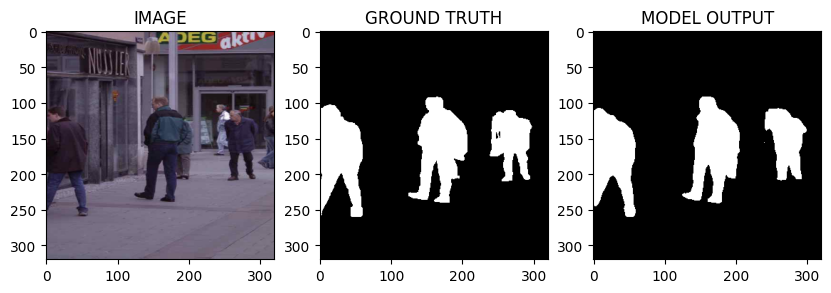

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))